In [71]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

In [73]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

# Magic super clean params: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}

sn.rescale_populations(1.0)
sn.rescale_connectivity(1)
sn.rescale_weights(1.79)
sn.rescale_delays(1)

poisson_rescale = 1.97

sn.build()

Output()

In [27]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)

## Input/Output

In [74]:
# pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
# sn.populations[pop_state_monitorized].monitorize_states()

In [75]:
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(1120, 0.45 * poisson_rescale)
sn.populations["D2"].add_poisson_spike_injector(972.927, 0.45 * poisson_rescale) 

In [76]:
sn.run(dt=0.1, time=5000)

Running network consisting of 14622 neurons for 50000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 84 s	(1.6814 ms/step)
	Gathering time avg: 0.12624 us/step
	Inject time avg: 136.286 us/step
Population evolution stats:
	0:
		evolution:	416.503 us/step	---	69 ns/step/neuron
		spike emission:	41.1458 us/step	---	6 ns/step/neuron
	1:
		evolution:	422.944 us/step	---	70 ns/step/neuron
		spike emission:	128.549 us/step	---	21 ns/step/neuron
	2:
		evolution:	90.672 us/step	---	215 ns/step/neuron
		spike emission:	28.7832 us/step	---	68 ns/step/neuron
	3:
		evolution:	113.027 us/step	---	144 ns/step/neuron
		spike emission:	30.1722 us/step	---	38 ns/step/neuron
	4:
		evolution:	64.3718 us/step	---	247 ns/step/neuron
		spike emission:	10.4558 us/step	---	40 ns/step/neuron
	5:
		evolution:	74.6383 us/step	---	182 ns/step/neuron
		spike emission:	6.72572 u

In [77]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

# states = sn.populations[pop_state_monitorized].get_data()['states']

Mean firing rate D1:	0.8 Hz
Mean firing rate D2:	5.2 Hz
Mean firing rate FSN:	47.8 Hz
Mean firing rate GPeTI:	109.1 Hz
Mean firing rate GPeTA:	23.0 Hz
Mean firing rate STN:	23.1 Hz
Mean firing rate SNR:	15.1 Hz


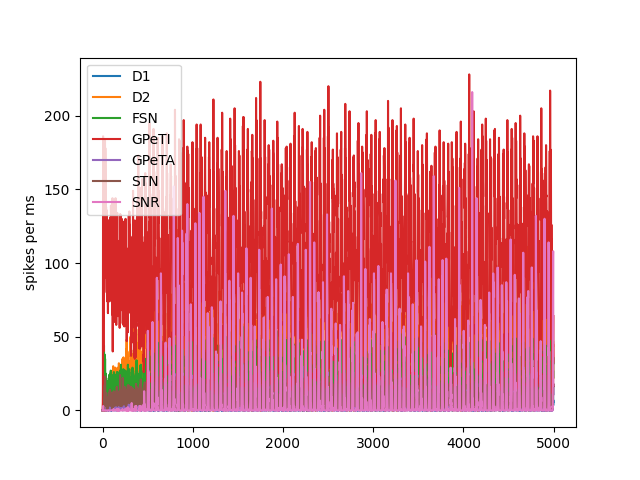

In [78]:
fig, ax = plt.subplots()
timesteps_per_bin = 10
binned_signals = dict()

for pop in spikes.keys():
    binned_signals[pop] = np.sum( 
                            spikes[pop][:(len(spikes[pop])//timesteps_per_bin)*timesteps_per_bin].reshape(-1, timesteps_per_bin),
                            axis=1).squeeze()
    
    mfr = np.mean(binned_signals[pop][200:]) * 1e3 / sn.populations[pop].n_neurons
    print(f"Mean firing rate {pop}:\t{mfr:.1f} Hz")
    plt.plot(binned_signals[pop], label=pop)
             
plt.legend()
plt.ylabel("spikes per ms");


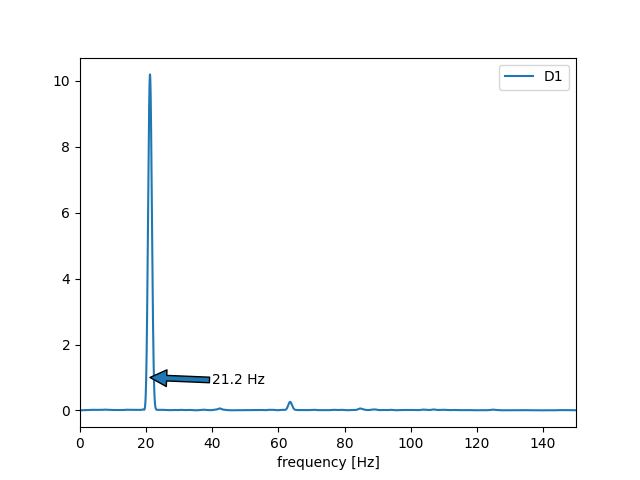

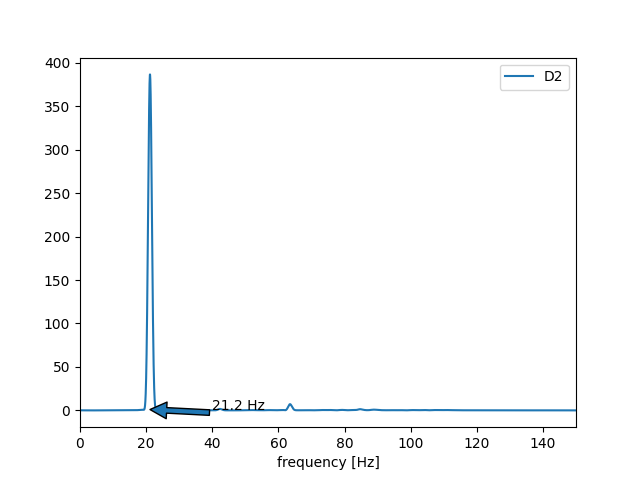

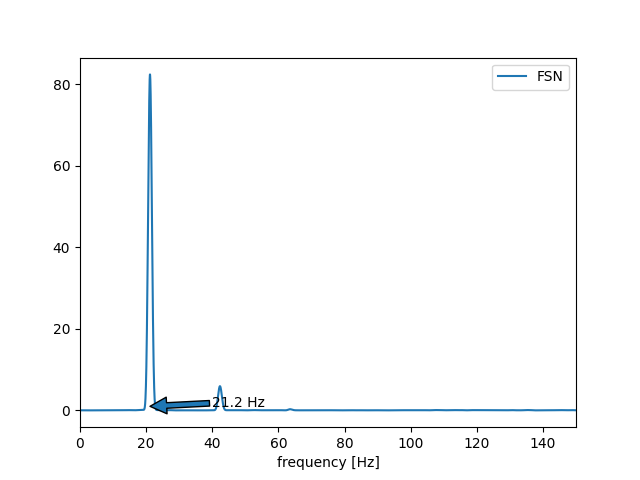

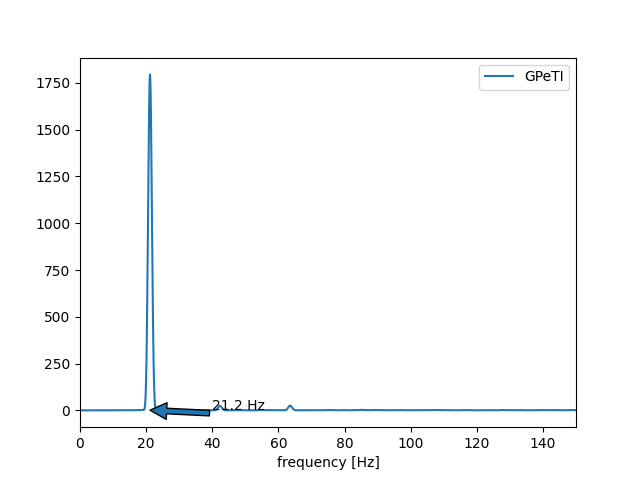

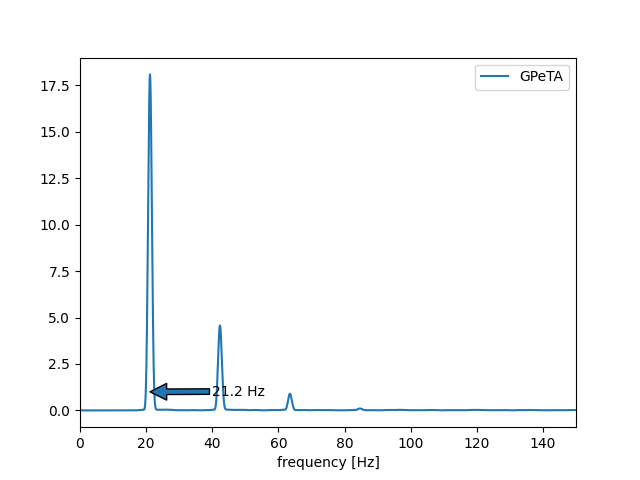

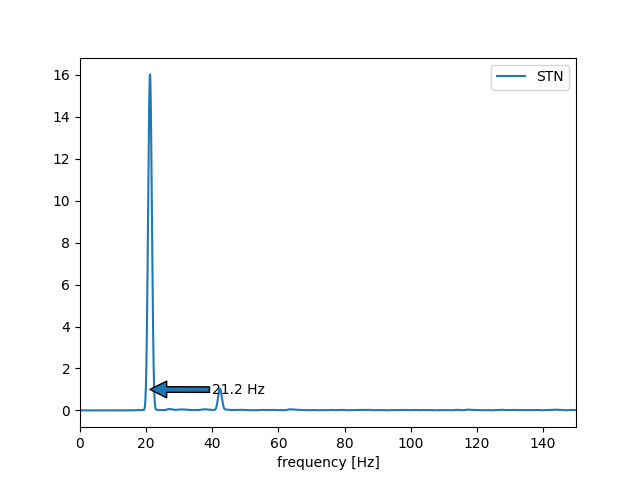

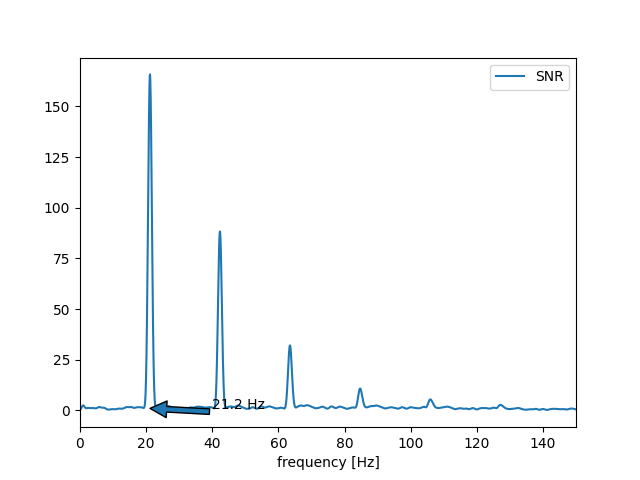

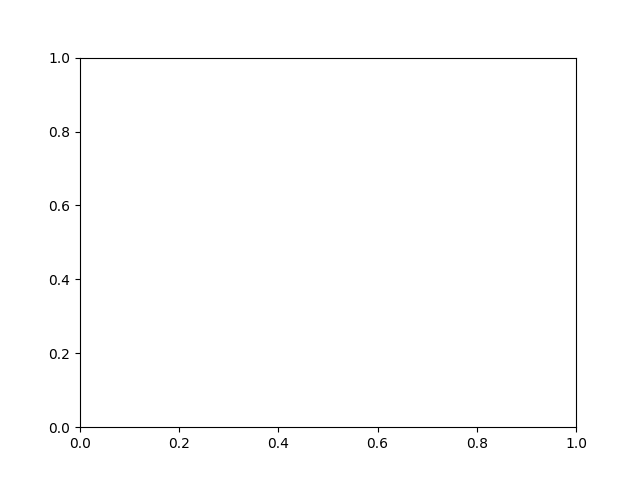

In [80]:
from numpy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from neurodsp.filt import filter_signal

fig, ax = plt.subplots()
scaler = MinMaxScaler()

burn_in = 200

def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

for pop in sn.populations.keys():
    signal = binned_signals[pop][burn_in:]
    # signal = bandpass(signal, [2, 150], 1000)
    fig, ax = plt.subplots()
    f, PSD = welch(signal, 
                   1000, 
                   nperseg=1000, 
                   noverlap=500,
                   nfft=30000,#None, 
                   scaling='density', 
                   window='hamming')
    # print(PSD)
    # plt.plot(f, scaler.fit_transform(PSD[:, None]).squeeze(), label=pop)
    plt.plot(f, PSD, label=pop)
    plt.annotate(f"{f[np.argmax(PSD)]:.1f} Hz", xy=(f[np.argmax(PSD)], 1), xytext= (40, 0.8), arrowprops=dict())
    plt.legend()
    plt.xlim(0,150)
    plt.xlabel("frequency [Hz]")

    plt.show()
    # break
# plt.xlim([0,50]);


In [ ]:
# fig,ax = plt.subplots()
# plt.plot(np.mean(states[:, :, 0], axis=1))
# plt.title(pop_state_monitorized+"V")
# # plt.xlim(0,1000)

In [ ]:
from scipy.signal import butter, sosfiltfilt, freqz

fig, ax = plt.subplots()

pop = "GPeTI"

tt = np.linspace(0, 8, 8000)

plt.plot(tt,binned_signals[pop])
plt.plot(tt, bandpass(binned_signals[pop], [12, 24], 1000))
plt.plot(tt, bandpass(binned_signals[pop], [30, 80], 1000))

# plt.plot(tt,np.sin(6.28* 20 * tt))
# plt.ylim(-11250,11250)

## Tuning

In [37]:
import optuna
optimize_population = "GPeTA"

def build_network(poisson_rescale, rescale_weights):
    catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")
    sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)

    sn.rescale_populations(1)
    sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    sn.rescale_delays(1)
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [600, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn

def beta_mean_power(sn):
    sn.run(dt=0.1, time=5000)
    
    timesteps_per_bin = 10
    sampling_frequency = 1e4/timesteps_per_bin
    
    binned_spikes = sn.populations[optimize_population].get_data()['spikes']
    binned_spikes = np.sum( 
                        binned_spikes[:(len(binned_spikes)//timesteps_per_bin)*timesteps_per_bin].reshape(-1, timesteps_per_bin),
                        axis=1).squeeze()

    binned_spikes = binned_spikes[200:]
    
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg=1000, 
                   noverlap=500,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    
    beta_mask = (f>12)&(f<30)
    
    return np.trapz(PSD[beta_mask], x=f[beta_mask])
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    return beta_mean_power(sn)
    

In [35]:
study = optuna.create_study(direction = 'maximize')
study.optimize(optimize_beta_power, n_trials = 5, n_jobs = -1, catch=(ValueError, TypeError))

[I 2024-01-19 18:21:42,016] A new study created in memory with name: no-name-60aaae28-d827-4f78-a4ec-c21e4931e4b5
[I 2024-01-19 18:23:31,430] Trial 1 finished with value: 27.961959015572617 and parameters: {'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}. Best is trial 1 with value: 27.961959015572617.


Running network consisting of 14622 neurons for 50000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 81 s	(1.62324 ms/step)
	Gathering time avg: 0.01122 us/step
	Inject time avg: 128.574 us/step
Population evolution stats:
	0:
		evolution:	408.128 us/step	---	68 ns/step/neuron
		spike emission:	41.9951 us/step	---	6 ns/step/neuron
	1:
		evolution:	405.764 us/step	---	67 ns/step/neuron
		spike emission:	129.435 us/step	---	21 ns/step/neuron
	2:
		evolution:	85.1592 us/step	---	202 ns/step/neuron
		spike emission:	28.6506 us/step	---	68 ns/step/neuron
	3:
		evolution:	106.711 us/step	---	136 ns/step/neuron
		spike emission:	28.157 us/step	---	36 ns/step/neuron
	4:
		evolution:	60.991 us/step	---	234 ns/step/neuron
		spike emission:	9.47336 us/step	---	36 ns/step/neuron
	5:
		evolution:	71.8581 us/step	---	176 ns/step/neuron
		spike emission:	6.26646 u

[I 2024-01-19 18:25:25,747] Trial 2 finished with value: 0.1195511495537176 and parameters: {'poisson_rescale': 1.0341208780463744, 'weight_rescale': 0.11154466655943228}. Best is trial 1 with value: 27.961959015572617.


Running network consisting of 14622 neurons for 50000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 114 s	(2.28572 ms/step)
	Gathering time avg: 0.04714 us/step
	Inject time avg: 164.689 us/step
Population evolution stats:
	0:
		evolution:	598.553 us/step	---	99 ns/step/neuron
		spike emission:	196.407 us/step	---	32 ns/step/neuron
	1:
		evolution:	504.507 us/step	---	84 ns/step/neuron
		spike emission:	231.106 us/step	---	38 ns/step/neuron
	2:
		evolution:	99.0108 us/step	---	235 ns/step/neuron
		spike emission:	58.5121 us/step	---	139 ns/step/neuron
	3:
		evolution:	120.875 us/step	---	154 ns/step/neuron
		spike emission:	36.2456 us/step	---	46 ns/step/neuron
	4:
		evolution:	63.6754 us/step	---	244 ns/step/neuron
		spike emission:	7.56924 us/step	---	29 ns/step/neuron
	5:
		evolution:	73.3449 us/step	---	179 ns/step/neuron
		spike emission:	9.14

[I 2024-01-19 18:26:43,930] Trial 0 finished with value: 0.22692079191425932 and parameters: {'poisson_rescale': 0.8272693767582819, 'weight_rescale': 1.4951277682533164}. Best is trial 1 with value: 27.961959015572617.


***************************************************
Simulation took 78 s	(1.56334 ms/step)
	Gathering time avg: 0.01482 us/step
	Inject time avg: 128.195 us/step
Population evolution stats:
	0:
		evolution:	408.717 us/step	---	68 ns/step/neuron
		spike emission:	79.6341 us/step	---	13 ns/step/neuron
	1:
		evolution:	402.951 us/step	---	67 ns/step/neuron
		spike emission:	53.7612 us/step	---	8 ns/step/neuron
	2:
		evolution:	87.5953 us/step	---	208 ns/step/neuron
		spike emission:	5.70162 us/step	---	13 ns/step/neuron
	3:
		evolution:	106.806 us/step	---	136 ns/step/neuron
		spike emission:	21.6084 us/step	---	27 ns/step/neuron
	4:
		evolution:	65.1076 us/step	---	250 ns/step/neuron
		spike emission:	5.7375 us/step	---	22 ns/step/neuron
	5:
		evolution:	75.8682 us/step	---	185 ns/step/neuron
		spike emission:	4.58984 us/step	---	11 ns/step/neuron
	6:
		evolution:	103.205 us/step	---	136 ns/step/neuron
		spike emission:	4.14486 us/step	---	5 ns/step/neuron
Running network consisting of 1

[I 2024-01-19 18:28:08,500] Trial 4 finished with value: 0.133559258895374 and parameters: {'poisson_rescale': 1.1649898415349147, 'weight_rescale': 0.39622405151577267}. Best is trial 1 with value: 27.961959015572617.


***************************************************
Simulation took 84 s	(1.69034 ms/step)
	Gathering time avg: 0.01028 us/step
	Inject time avg: 136.466 us/step
Population evolution stats:
	0:
		evolution:	418.171 us/step	---	69 ns/step/neuron
		spike emission:	50.3147 us/step	---	8 ns/step/neuron
	1:
		evolution:	417.195 us/step	---	69 ns/step/neuron
		spike emission:	117.301 us/step	---	19 ns/step/neuron
	2:
		evolution:	85.6439 us/step	---	203 ns/step/neuron
		spike emission:	47.0278 us/step	---	111 ns/step/neuron
	3:
		evolution:	111.723 us/step	---	143 ns/step/neuron
		spike emission:	35.4004 us/step	---	45 ns/step/neuron
	4:
		evolution:	64.5 us/step	---	248 ns/step/neuron
		spike emission:	7.80478 us/step	---	30 ns/step/neuron
	5:
		evolution:	74.7279 us/step	---	183 ns/step/neuron
		spike emission:	7.8739 us/step	---	19 ns/step/neuron
	6:
		evolution:	103.143 us/step	---	136 ns/step/neuron
		spike emission:	3.64638 us/step	---	4 ns/step/neuron


[I 2024-01-19 18:29:32,186] Trial 3 finished with value: 0.3730664865283314 and parameters: {'poisson_rescale': 0.9789452326943139, 'weight_rescale': 1.5727293394529607}. Best is trial 1 with value: 27.961959015572617.


Running network consisting of 14622 neurons for 50000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 83 s	(1.67352 ms/step)
	Gathering time avg: 0.01608 us/step
	Inject time avg: 135.92 us/step
Population evolution stats:
	0:
		evolution:	459.024 us/step	---	76 ns/step/neuron
		spike emission:	64.9341 us/step	---	10 ns/step/neuron
	1:
		evolution:	420.709 us/step	---	70 ns/step/neuron
		spike emission:	79.6639 us/step	---	13 ns/step/neuron
	2:
		evolution:	90.9602 us/step	---	216 ns/step/neuron
		spike emission:	9.86298 us/step	---	23 ns/step/neuron
	3:
		evolution:	112.221 us/step	---	143 ns/step/neuron
		spike emission:	23.7233 us/step	---	30 ns/step/neuron
	4:
		evolution:	66.7379 us/step	---	256 ns/step/neuron
		spike emission:	6.68776 us/step	---	25 ns/step/neuron
	5:
		evolution:	77.7721 us/step	---	190 ns/step/neuron
		spike emission:	5.04094

{'poisson_rescale': 1.9739110331634744, 'weight_rescale': 1.7952043585344422}
Running network consisting of 14622 neurons for 50000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 91 s	(1.82022 ms/step)
	Gathering time avg: 0.08048 us/step
	Inject time avg: 142.196 us/step
Population evolution stats:
	0:
		evolution:	490.695 us/step	---	81 ns/step/neuron
		spike emission:	50.0896 us/step	---	8 ns/step/neuron
	1:
		evolution:	449.521 us/step	---	74 ns/step/neuron
		spike emission:	135.154 us/step	---	22 ns/step/neuron
	2:
		evolution:	93.6407 us/step	---	222 ns/step/neuron
		spike emission:	31.442 us/step	---	74 ns/step/neuron
	3:
		evolution:	117.112 us/step	---	150 ns/step/neuron
		spike emission:	30.8103 us/step	---	39 ns/step/neuron
	4:
		evolution:	65.5976 us/step	---	252 ns/step/neuron
		spike emission:	10.9809 us/step	---	42 ns/step/neuron
	5:


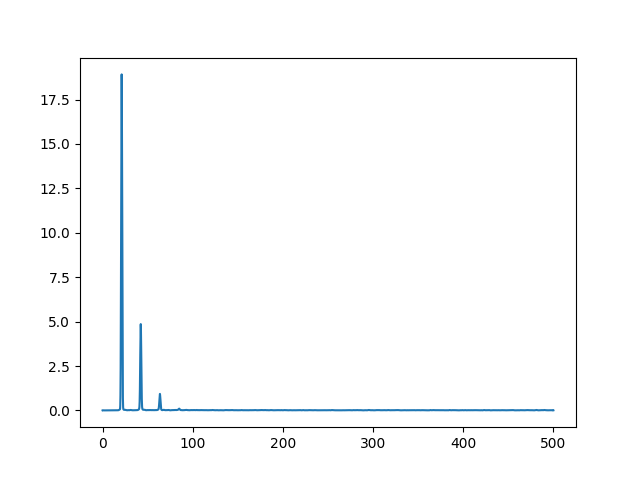

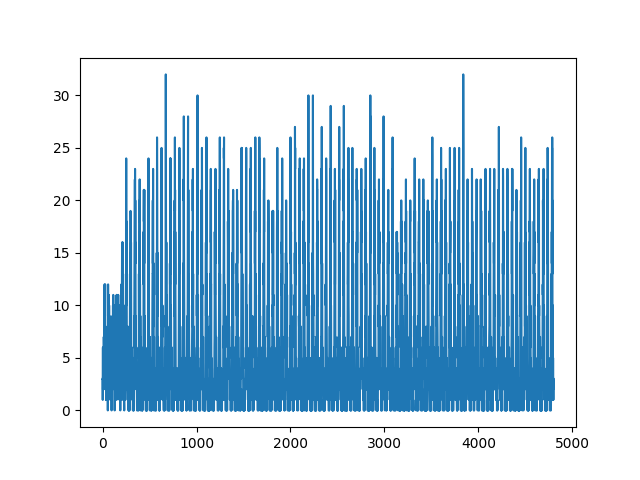

In [38]:
best_params = study.best_params
print(best_params)
sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
print(beta_mean_power(sn))

MFR D1 4.558125
MFR D2 31.091041666666666
MFR FSN 20.072916666666668
MFR GPeTI 85.07208333333334
MFR GPeTA 5.98
MFR STN 9.427916666666667
MFR SNR 11.359791666666666
F resolution  0.5


(0.0, 150.0)

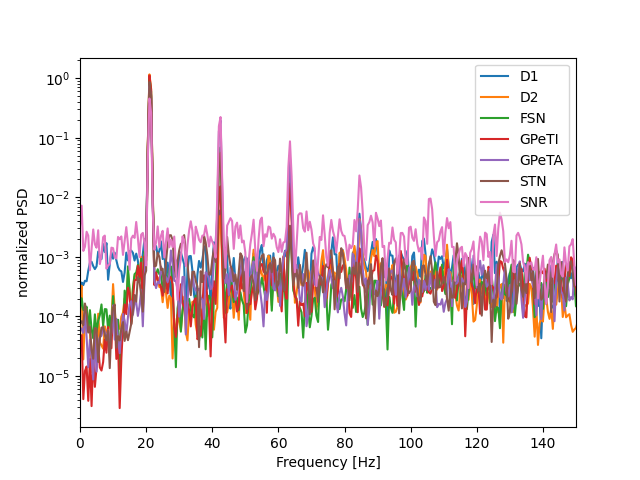

In [84]:
from scipy.integrate import simpson

timesteps_per_bin = 10
sampling_frequency = 1e4/timesteps_per_bin
fig, ax = plt.subplots()
for pop in sn.populations:
    binned_spikes = sn.populations[pop].get_data()['spikes']
    binned_spikes = np.sum( 
                        binned_spikes[:(len(binned_spikes)//timesteps_per_bin)*timesteps_per_bin].reshape(-1, timesteps_per_bin),
                        axis=1).squeeze()
    binned_spikes = binned_spikes[200:]
    print("MFR", pop, np.mean(binned_spikes))
    f, PSD = welch(binned_spikes, 
                   1000, 
                   nperseg=2000, 
                   noverlap=1000,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')

    norm = simpson(PSD, x=f)
    plt.plot(f, PSD/norm, label=pop)
print("F resolution ", f[1] - f[0])
plt.yscale('log')
plt.legend()
plt.ylabel("normalized PSD")
plt.xlabel("Frequency [Hz]")
plt.xlim(0,150)
# fig, ax = plt.subplots()
# plt.plot(binned_spikes)